In [1]:
import numpy as np
import torch
from torch.optim import Adam
import torch.nn.functional as F
from tqdm import tqdm
import torch.nn as nn

from util import *
from model import *
from input_data import adj_train, adj_norm, adj_label, norm, weight_tensor, adj_orig, cpt, bi_train, bi_adj_norm, biadj_label, norm_bi, weight_tensor_bi, cpt_tensor, train_edges, val_edges, val_edges_false, test_edges, test_edges_false
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
	torch.set_default_tensor_type('torch.cuda.FloatTensor')

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


loaded adj_norm, adj_label, norm, weight_tensor
loaded bi_train, train_edges_bi, val_edges_bi, val_edges_false_bi, test_edges_bi, test_edges_false_bi
loaded bi_adj_norm, biadj_label, norm_bi, weight_tensor_bi


# Training

In [2]:
feature = create_feature(adj_norm.shape[0])
feature = prepare_features_for_training(feature)

input_dim = feature.shape[1]
bipartite_dim = cpt.shape[1]

adj_norm = adj_norm.to(device)
adj_label = adj_label.to(device)
biadj_label = biadj_label.to(device)
# cpt_tensor = cpt_tensor.to(device)
bi_adj_norm = bi_adj_norm.to(device).T

In [3]:
# adj_orig = adj_orig.to(device)
weight_tensor = weight_tensor.to(device)
weight_tensor_bi = weight_tensor_bi.to(device)
feature = feature.to(device)
dropout = 0.0
model = HeteroVGAE(input_dim, bipartite_dim, hidden1_dim=4, hidden2_dim=2, dropout=dropout)
model = model.to(device)
optimizer = Adam(model.parameters(), lr=0.01)

In [4]:
model

HeteroVGAE(
  (base_gcn): GraphConvSparse (4455 ->4)
  (gcn_mean): GraphConvSparse (4 ->2)
  (gcn_logstddev): GraphConvSparse (4 ->2)
  (mlp): MLP (4455 ->4 ->2)
  (decoder): EdgeDecoder ( (z_company: 2->4555) (z_term: 2->4555))
)

In [5]:
def train(epoch):
    history = {'loss':[], 'acc':[], 'ap':[], 'roc':[]}

    model.train()
    for i in tqdm(range(epoch)):
        z_c, z_t, A_pred, Bi_pred = model(feature, adj_norm, bi_adj_norm)

        users_zc = z_c.clone()
        users_zc[16] = z_c[28]
        # print(users_zc[16])
        # print(z_c[16])
        # print(z_c[28])


        optimizer.zero_grad()

        loss = model.loss_function(norm, norm_bi, adj_label, biadj_label, A_pred, Bi_pred, weight_tensor, weight_tensor_bi, users_zc)

        loss.backward()
        optimizer.step()

        # embedding_company = z_c.cpu().detach().numpy()
        # embedding_term = z_t.cpu().detach().numpy()
        # # train_acc = get_acc(A_pred, adj_label)
        # roc_curr, ap_curr = get_scores(embedding_company, adj_orig, val_edges, val_edges_false)

        history['loss'].append(loss.item())
        # history['acc'].append(train_acc.item())
        # history['ap'].append(ap_curr)
        # history['roc'].append(roc_curr)

        # print("Epoch:", '%04d' % (i + 1), "train_loss=", "{:.5f}".format(loss.item()),
        #       "train_acc=", "{:.5f}".format(train_acc),
        #       "val_ap=", "{:.5f}".format(ap_curr), 
        #       "val_roc=", "{:.5f}".format(roc_curr))
        if i % 100 == 0:
            print(loss.item())
        embedding_company = z_c.to('cpu').detach()
        embedding_term = z_t.to('cpu').detach()
    return model, embedding_company, embedding_term, A_pred, history

In [6]:
def test(model, emb, test_edges, test_edges_false):
    model.eval()
    test_roc, test_ap = get_scores(emb, adj_label, test_edges, test_edges_false)
    print("End of training!", "test_roc=", "{:.5f}".format(test_roc),
      "test_ap=", "{:.5f}".format(test_ap))

def test_z(model, test_adj, test_x):
    model.eval()
    test_z = model.encode(test_x, test_adj)
    return test_z

In [7]:
num_train = 1000
model, embedding_company, embedding_term, A_pred, history = train(num_train)
torch.save(model.state_dict(), "/app/model/model-4.pt")

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 5/1000 [00:00<00:51, 19.45it/s]

577546.5625


 10%|█         | 105/1000 [00:03<00:27, 32.84it/s]

2207082.0


 20%|██        | 205/1000 [00:06<00:24, 32.87it/s]

85944.40625


 30%|███       | 305/1000 [00:09<00:21, 33.09it/s]

238.95750427246094


 40%|████      | 405/1000 [00:12<00:18, 33.02it/s]

1520.2724609375


 50%|█████     | 505/1000 [00:15<00:15, 32.88it/s]

1234.3843994140625


 60%|██████    | 605/1000 [00:18<00:11, 33.47it/s]

98.7576675415039


 70%|███████   | 705/1000 [00:21<00:08, 32.95it/s]

130.7340545654297


 80%|████████  | 805/1000 [00:24<00:05, 33.15it/s]

30.829483032226562


 90%|█████████ | 905/1000 [00:27<00:02, 33.16it/s]

133.99908447265625


100%|██████████| 1000/1000 [00:30<00:00, 32.99it/s]


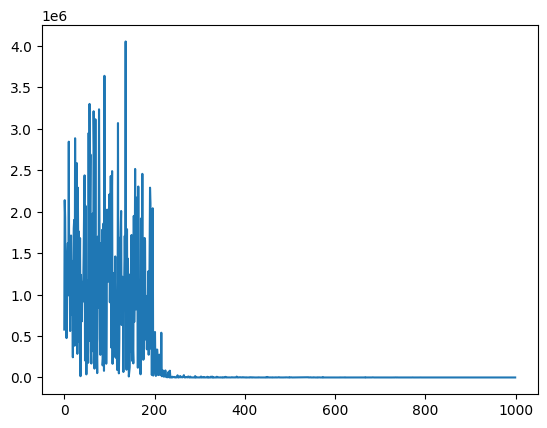

In [8]:
# plot history
import matplotlib.pyplot as plt
plt.plot(history['loss'])

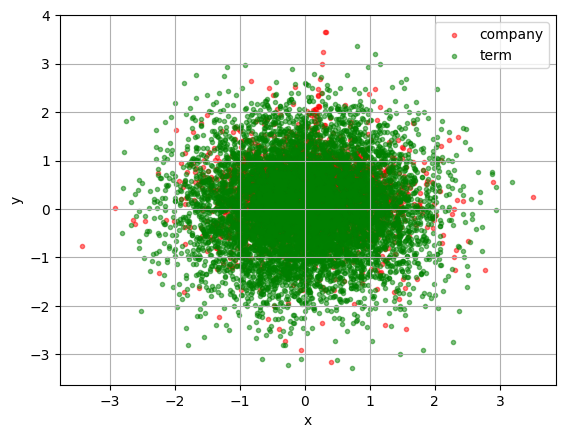

In [9]:
import matplotlib.pyplot as plt
company_x = embedding_company[:, 0]
company_y = embedding_company[:, 1]
term_x = embedding_term[:, 0]
term_y = embedding_term[:, 1]
plt.scatter(company_x, company_y, marker='.', label='company', color='red', alpha=0.5)
plt.scatter(term_x, term_y, marker='.', label='term', color='green', alpha=0.5)
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('/app/res/embedding-1.png')

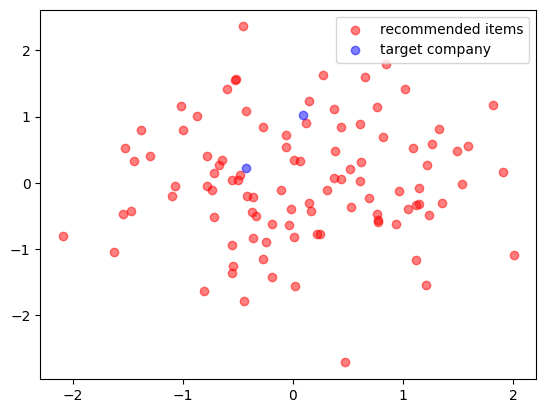

In [10]:
recommended_items_x = embedding_term[[i for i in range(100)], 0]
recommended_items_y = embedding_term[[i for i in range(100)], 1]
target_company_x = embedding_company[[18, 26], 0]
target_company_y = embedding_company[[18, 26], 1]


plt.scatter(recommended_items_x, recommended_items_y, c='red', alpha=0.5, label='recommended items')
plt.scatter(target_company_x, target_company_y, c='blue', alpha=0.5, label='target company')
plt.legend(loc='best', fontsize=10)

In [11]:
embedding_term

tensor([[ 0.2480, -0.7743],
        [ 2.0071, -1.0920],
        [ 0.7716, -0.5947],
        ...,
        [-0.7720, -1.1732],
        [ 1.0430,  0.2776],
        [ 0.3484, -0.7052]], device='cpu')

In [12]:
embedding_company[18]

tensor([-0.4238,  0.2260], device='cpu')

In [13]:
embedding_company[26]

tensor([0.0952, 1.0175], device='cpu')

In [14]:
# index -> 28:熊谷組， 16:清水建設
target_company_index = [16, 28]
target_index = 28
recommended_index = recommendable_items(embedding_company, embedding_term, 28, 100)

In [15]:
graph = load_binary('/app/data/bipartite_graph.pkl')
num_company:int = len({n for n, d in graph.nodes(data=True) if d["bipartite"] == 'company'})
company:list = list(graph.nodes)[:num_company]
term:list = list(graph.nodes)[num_company:]

In [16]:
recommended_items = [term[i] for i in recommended_index]

In [17]:
def eval(term1, companyIndex, recommendable_items):

    term2 = [term[i] for i in range(len(term)) if cpt[companyIndex, i] == 1]

    # recommendable_itemsの中で，term1とterm2の両方に含まれる割合を抽出
    term1_index = [i for i in range(len(term)) if term[i] in term1]
    term2_index = [i for i in range(len(term)) if term[i] in term2]
    recommendable_items_index = [i for i in range(len(term)) if term[i] in recommendable_items]
    term1_and_term2 = [i for i in recommendable_items_index if i in term1_index and i in term2_index]
    cover = len(term1_and_term2) / len(recommendable_items_index)

    # recommendable_itemsの中で，term1に含まれ，term2に含まれない割合を抽出
    term1_not_term2 = [i for i in recommendable_items_index if i in term1_index and i not in term2_index]
    term1_not_term2_term_list = [term[i] for i in term1_not_term2]
    cover_not_term2 = len(term1_not_term2) / len(recommendable_items_index)

    # recommendable_itemsの中で，term1には含まれず，term2に含まれる割合を抽出
    not_term1_term2 = [i for i in recommendable_items_index if i not in term1_index and i in term2_index]
    not_term1_term2_term_list = [term[i] for i in not_term1_term2]
    cover_not_term1 = len(not_term1_term2) / len(recommendable_items_index)
    
    # recommendable_itemsの中で，term1には含まれず，term2にも含まれない割合を抽出
    not_term1_not_term2 = [i for i in recommendable_items_index if i not in term1_index and i not in term2_index]
    not_term1_not_term2_term_list = [term[i] for i in not_term1_not_term2]
    cover_not_term1_not_term2 = len(not_term1_not_term2) / len(recommendable_items_index)

    return cover, cover_not_term2, cover_not_term1, cover_not_term1_not_term2, term1_not_term2_term_list, not_term1_term2_term_list, not_term1_not_term2_term_list

In [18]:
patent_company = load_binary('/app/data/patent_company.pkl')
patent_term = load_binary('/app/data/patent_term.pkl')
cpc = clamp(torch.matmul(patent_company.T, patent_company), 0, 1).to('cpu')
cpt = clamp(torch.matmul(patent_company.T, patent_term), 0, 1).to('cpu')

In [19]:
kumagai_term = [term[i] for i in range(len(term)) if cpt[target_company_index[0], i] == 1]

In [20]:
cover, cover_not_term2, cover_not_term1, cover_not_term1_not_term2, term1_not_term2_term_list, not_term1_term2_term_list, not_term1_not_term2_term_list = eval(kumagai_term, target_company_index[1], recommended_items)

In [21]:
cover

0.42

In [22]:
cover_not_term1

0.04

In [23]:
not_term1_term2_term_list

['上車輪', '被覆電線', '先端キャップ', '破壊用物質']

In [24]:
cover_not_term2

0.35

In [25]:
term1_not_term2_term_list

['スライド支承',
 '浄化材料',
 '工空間',
 '有線ケーブル',
 '防火シャッター',
 '発泡樹脂ブロック',
 'エレベータ設備',
 'タイプレート',
 '膨張タンク',
 '排出経路',
 '転倒防止装置',
 '鋼板パネル',
 '処理ユニット',
 'サイドフレーム',
 '移動部材',
 '連絡坑',
 '桁ブロック',
 '養生部材',
 '土留め構造',
 'ベントナイト泥水',
 '防水テープ',
 '振動磁界',
 '検出コイル',
 '切替機構',
 '進退機構',
 'コンクリートピット',
 'コンクリート打設ホース',
 '設置領域',
 'インバータ装置',
 '木質構造部材',
 '液圧配管',
 '二鉄筋',
 '手摺支柱',
 '遮光装置',
 '冷暖房用パイプ']

In [26]:
cover_not_term1_not_term2

0.19

In [27]:
not_term1_not_term2_term_list

['光ファイバーケーブル',
 '式表現',
 '操作杆',
 '植栽層',
 '基礎フレーム',
 '旋回環',
 '透光パネル',
 '通水パイプ',
 '投射ガイド',
 '斜面監視装置',
 '筒状フレーム',
 '台座コンクリート',
 'エアーノズル',
 '冷媒液配管',
 '接合シート',
 '固定攪拌翼',
 'セメントミルク供給装置',
 '還元装置',
 '短尺切梁']